# Import Data

In [2]:
# Import libraries
from IPython.display import display, HTML # Display functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette("colorblind") 
sns.set_style("darkgrid")

import os

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import geospaitial libraries
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Read data
path = "../data/raw/2004-2019.tsv.zip"

df = pd.read_csv(path, sep='\t',parse_dates=True)
df.head()

,Unnamed: 0,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
0,0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106823 entries, 0 to 106822
Data columns (total 21 columns):
Unnamed: 0                       106823 non-null int64
DATA INICIAL                     106823 non-null object
DATA FINAL                       106823 non-null object
REGIÃO                           106823 non-null object
ESTADO                           106823 non-null object
PRODUTO                          106823 non-null object
NÚMERO DE POSTOS PESQUISADOS     106823 non-null int64
UNIDADE DE MEDIDA                106823 non-null object
PREÇO MÉDIO REVENDA              106823 non-null float64
DESVIO PADRÃO REVENDA            106823 non-null float64
PREÇO MÍNIMO REVENDA             106823 non-null float64
PREÇO MÁXIMO REVENDA             106823 non-null float64
MARGEM MÉDIA REVENDA             106823 non-null object
COEF DE VARIAÇÃO REVENDA         106823 non-null float64
PREÇO MÉDIO DISTRIBUIÇÃO         106823 non-null object
DESVIO PADRÃO DISTRIBUIÇÃO       106823 non-nu

# Clean Data

## Fix column labels

A glance at the raw data shows that:
* Columns are in Portuguese and will be translated into English for convenience
* Column names will be cleaned and standardized
* Dates will be converted to Datetime objects
* Unecessary columns will be removed

In [5]:
# Translate column names to English
df.columns = ["Unnamed:_0", 
"Analysis_Date",
"Last day of analyses of week",
"Macroregion",
"State",
"Product",
"No of Gas Stations Analyzed",
"Measurement unit",
"Mean Price",
"Std Dev",
"Min Price",
"Max Price",
"Mean Price Margin",
"Coefficient of variation",
"Mean Dist Price",
"Distribution Std Dev",
"Distribution Min Price",
"Distribution Max Price",
"Distribution Coefficient of Variation",
"Month",
"Year"]

# Replace whitespace with underscore
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("'", "")
df.columns = df.columns.str.replace("Distribution", "Dist")

# Convert datetime columns to datetime objects and rename
df["Analysis_Date"] = pd.to_datetime(df["Analysis_Date"])

## Fix Values, Datatypes, and NULLs

Cleaning the dataset requires a specific strategy: 
* Correct inappropriate characters
* Address NULL values
* Convert datatypes

For this particular dataset:
* Fix inappropriate string characters in several columns that should be numeric
* Translate categories in the *Product* column
* Rename *Measurement_unit* categories
* Convert object types to category type

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106823 entries, 0 to 106822
Data columns (total 21 columns):
Unnamed:_0                       106823 non-null int64
Analysis_Date                    106823 non-null datetime64[ns]
Last_day_of_analyses_of_week     106823 non-null object
Macroregion                      106823 non-null object
State                            106823 non-null object
Product                          106823 non-null object
No_of_Gas_Stations_Analyzed      106823 non-null int64
Measurement_unit                 106823 non-null object
Mean_Price                       106823 non-null float64
Std_Dev                          106823 non-null float64
Min_Price                        106823 non-null float64
Max_Price                        106823 non-null float64
Mean_Price_Margin                106823 non-null object
Coefficient_of_variation         106823 non-null float64
Mean_Dist_Price                  106823 non-null object
Dist_Std_Dev                     10682

In [7]:
# Correct dtypes
float_columns = ['Mean_Price_Margin', 'Mean_Dist_Price', 'Dist_Std_Dev',
       'Dist_Min_Price', 'Dist_Max_Price',
       "Dist_Coefficient_of_Variation"]

# Replace "-" with 0 in order to convert to float
for column in float_columns:
    df[column] = df[column].str.replace("-", "0")

# Fill nulls and convert to float
df[float_columns] = df[float_columns].fillna(0).astype(float)

assert df[float_columns].dtypes.all() == np.float64

# Rename Product categories
products = {"ÓLEO DIESEL":"DIESEL", "GASOLINA COMUM":"PETROL", "GLP":"LPG", 
            "ETANOL HIDRATADO":"HYDROUS ETHANOL", "GNV":"NATURAL GAS", "ÓLEO DIESEL S10":"DIESEL S10"}

df["Product"] = df.Product.map(products)

# Rename Measurement_unit categories
units = {"R$/l":"liter", "R$/13Kg":"13kg", "R$/m3":"m3"}

df["Measurement_unit"] = df["Measurement_unit"].map(units)

# Convert objects to category
object_cols = df.select_dtypes(include='object').columns
df[object_cols] = df[object_cols].astype('category', inplace=True)

## Feature Enginering

New columns created:
* Price_Group - separating LPG from the other fuels for easier visualization
* Mean_Price_Norm - Normalized Mean_Price by fuel Product
* Year_Month - for time series plots

In [8]:
# Create Price Groups: Group 1 are liquid fuels plus Natural Gas, Group 2 is LPG
df['Price_Group'] = df.Measurement_unit.map({'liter':int(1), 'm3':int(1), '13kg':int(2)})

# Normalize Mean Price for each fuel group
normalizer = lambda x: (x - x.min()) / (x.max() - x.min())

# Normalize Prices for Price_Group_1: all fuels except LPG
df["Mean_Price_Norm_Price_Group_1"] = df[df.Price_Group==1].groupby("Product")["Mean_Price"].transform(normalizer)

# Normalize Prices for Price_Group_2: LPG
df["Mean_Price_Norm_Price_Group_2"] = df[df.Price_Group==2].groupby("Product")["Mean_Price"].transform(normalizer)

# Combine Price_Group columns into one column
df["Mean_Price_Norm"] = df["Mean_Price_Norm_Price_Group_1"].fillna(df["Mean_Price_Norm_Price_Group_2"])
df.drop(["Mean_Price_Norm_Price_Group_1", "Mean_Price_Norm_Price_Group_2"], axis=1, inplace=True)

# Create Year_Month column for time series plots
year_month = df.Year.astype(str) + "-" + df.Month.astype(str)
df["Year_Month"] = pd.to_datetime(year_month)

Double check that the values were correctly normalized:

In [9]:
# Check max/min values of each Product group to ensure that they were properly normalized
products = df.Product.unique().tolist()

for product in range(len(products)):
    mins = df[df.Product==products[product]]["Mean_Price_Norm"].min()
    maxs = df[df.Product==products[product]]["Mean_Price_Norm"].max()
    
    print(products[product])
    print(mins, maxs)

HYDROUS ETHANOL
0.0 1.0
PETROL
0.0 1.0
LPG
0.0 1.0
NATURAL GAS
0.0 1.0
DIESEL
0.0 1.0
DIESEL S10
0.0 1.0


## Drop unecessary columns

In [10]:
df.drop(['Unnamed:_0', 'Last_day_of_analyses_of_week'], axis = 1, inplace=True)

## Save clean data to file

In [11]:
display(df.head())

df.to_csv('../data/interim/fuel_in_brazil_clean.csv')

,Analysis_Date,Macroregion,State,Product,No_of_Gas_Stations_Analyzed,Measurement_unit,Mean_Price,Std_Dev,Min_Price,Max_Price,Mean_Price_Margin,Coefficient_of_variation,Mean_Dist_Price,Dist_Std_Dev,Dist_Min_Price,Dist_Max_Price,Dist_Coefficient_of_Variation,Month,Year,Price_Group,Mean_Price_Norm,Year_Month
0,2004-05-09,CENTRO OESTE,DISTRITO FEDERAL,HYDROUS ETHANOL,127,liter,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.110,0.4201,0.96660,0.133,5,2004,1,0.141348,2004-05-01
1,2004-05-09,CENTRO OESTE,GOIAS,HYDROUS ETHANOL,387,liter,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05000,0.115,5,2004,1,0.107230,2004-05-01
2,2004-05-09,CENTRO OESTE,MATO GROSSO,HYDROUS ETHANOL,192,liter,1.389,0.097,1.18,1.760,0.419,0.070,0.970,0.095,0.5614,1.16100,0.098,5,2004,1,0.168698,2004-05-01
3,2004-05-09,CENTRO OESTE,MATO GROSSO DO SUL,HYDROUS ETHANOL,162,liter,1.262,0.070,1.09,1.509,0.432,0.055,0.830,0.119,0.5991,1.22242,0.143,5,2004,1,0.134308,2004-05-01
4,2004-05-09,NORDESTE,ALAGOAS,HYDROUS ETHANOL,103,liter,1.181,0.078,1.05,1.400,0.240,0.066,0.941,0.077,0.7441,1.03170,0.082,5,2004,1,0.112375,2004-05-01


# Exploratory Data Analysis

The questions posed by this analysis can be answered with *Mean_Price*. The other numeric variables can be excluded with the exception of *Mean_Dist_Price* because of some interesting behavior we will look at. The columns included in this analysis will be:
* Analysis_Date
* Macroregion
* State
* Product
* No_of_Gas_Stations_Analyzed
* Measurement_unit
* Mean_Price
* Mean_Dist_Price
* Month
* Year
* Price_Group

In [12]:
# Drop unneeded columns
df.drop(['Std_Dev', 
         'Min_Price', 'Max_Price', 'Mean_Price_Margin', 
         'Coefficient_of_variation', 
         'Dist_Std_Dev', 'Dist_Min_Price', 'Dist_Max_Price', 
         'Dist_Coefficient_of_Variation'], axis = 1, inplace=True)

# Save to clean data folder
df.to_csv('../data/processed/fuel_in_brazil_clean.csv')

## Helper Functions

### count_plot( )

In [13]:
def count_plot(column, df, title=None, xlabel=None, ylabel=None, rot=None):

    fig, ax = plt.subplots(figsize=(14,6))
    ax = sns.countplot(x=column, data=df)
    plt.title(title, fontsize=28)
    plt.xlabel(ylabel, fontsize=22)
    plt.ylabel(xlabel, fontsize=24)
    plt.xticks(rotation=rot, fontsize=20)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    
    plt.show()

### ecdf( ) - Plot empirical distribution function (ECDF)

In [14]:
# Define ECDF function
def ecdf(data, column, title=None, color=None):
    n = len(data[column])
    x = np.sort(data[column])
    y = np.arange(1, n+1)/n
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(x, y, marker='.', linestyle='none', color=color)
    plt.title(title)
    plt.xlabel("{}".format(column))
    plt.ylabel("ECDF")

### ecdf_category( ) - Plot multiple ECDFs by column category

In [15]:
def ecdf_category(column, group, title=None, xlabel=None):

    # Create figure with ECDF plots for each fuel Mean Price 
    products = df[group].unique().tolist()

    # Group dataframe by Product and select Mean Price
    product_group = df.groupby(group)[column]

    # Set rows and columns
    ncols = int(3)
    nrows = int(len(products) / ncols if len(products) % 2 == 0 else (len(products) + 1) / ncols)
    

    # List of colors
    color = ["b", "y", "g", "m", "r", "c"]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))

    # Index counter
    n = 0

    # Create subplots
    for row in range(nrows):
        for col in range(ncols):
        
            df_product = product_group.get_group(products[n]).to_frame("Mean Price")
   
            x = np.sort(df_product["Mean Price"]) 
            y = np.arange(1, len(df_product["Mean Price"])+1) / len(df_product["Mean Price"])
        
            ax[row,col].step(x, y, color=color[n])
            ax[row,col].set_ylabel("ECDF")
            ax[row,col].set_xlabel(xlabel)
            ax[row,col].set_title(products[n])
        
            n += 1

    plt.tight_layout(pad=5)
    plt.suptitle(title, fontsize=18)
    
    return plt.show()

## Feature by Feature Analysis

### Categorical Variables

Categorical variables should not be confused with the category datatype. The categorical variables are:
* Macroregion
* State
* Product
* Measurement_unit
* Price_Group

#### *Macroregion*

In [16]:
# Show names and percentage of observations for each macroregion
df.Macroregion.value_counts(normalize=True)

NORDESTE        0.345141
NORTE           0.231242
SUDESTE         0.159582
CENTRO OESTE    0.144435
SUL             0.119600
Name: Macroregion, dtype: float64

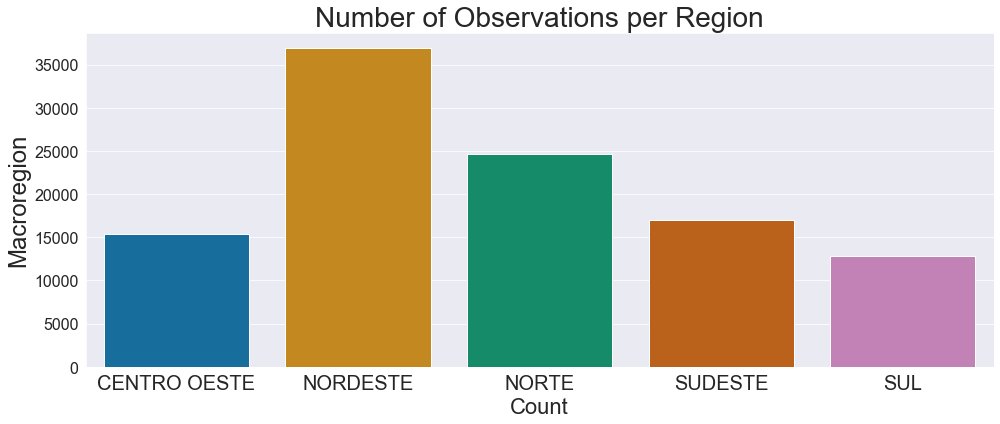

In [17]:
# Countplot of observations per Macroregion
count_plot("Macroregion", df, title="Number of Observations per Region", xlabel='Macroregion', ylabel='Count')

### *State*

States are found within macroregions. The dataset has observations more or less evenly distributed across the *State* column, not the *Macroregion* column.

In [18]:
# Examine number of observations per state
df['State'].value_counts()

BAHIA                  4263
SAO PAULO              4263
PARAIBA                4263
CEARA                  4263
RIO DE JANEIRO         4263
RIO GRANDE DO SUL      4263
RIO GRANDE DO NORTE    4262
PERNAMBUCO             4262
SANTA CATARINA         4262
MINAS GERAIS           4261
ESPIRITO SANTO         4260
SERGIPE                4259
PARANA                 4251
ALAGOAS                4250
MATO GROSSO DO SUL     4246
MATO GROSSO            4037
AMAZONAS               3889
GOIAS                  3663
PIAUI                  3548
MARANHAO               3499
PARA                   3497
TOCANTINS              3483
DISTRITO FEDERAL       3483
ACRE                   3480
RONDONIA               3479
RORAIMA                3471
AMAPA                  3403
Name: State, dtype: int64

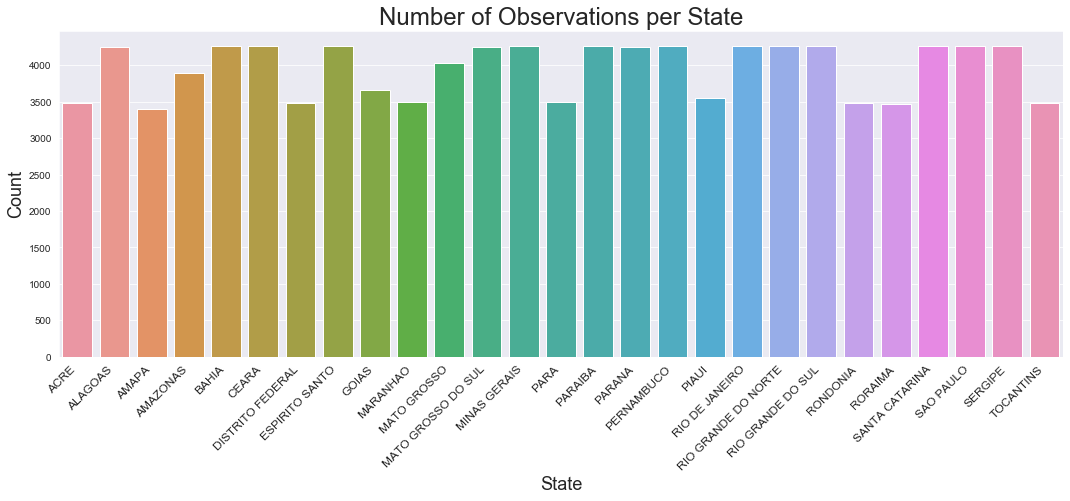

In [19]:
# Countplot of observations per State
fig, ax = plt.subplots(figsize=(18,6))
ax = sns.countplot(x="State", data=df)
plt.title("Number of Observations per State", fontsize=24)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

### *Product*

In [20]:
# Display percentages of products
df['Product'].value_counts(normalize=True)

PETROL             0.198403
DIESEL             0.198403
LPG                0.198328
HYDROUS ETHANOL    0.197542
NATURAL GAS        0.122015
DIESEL S10         0.085309
Name: Product, dtype: float64

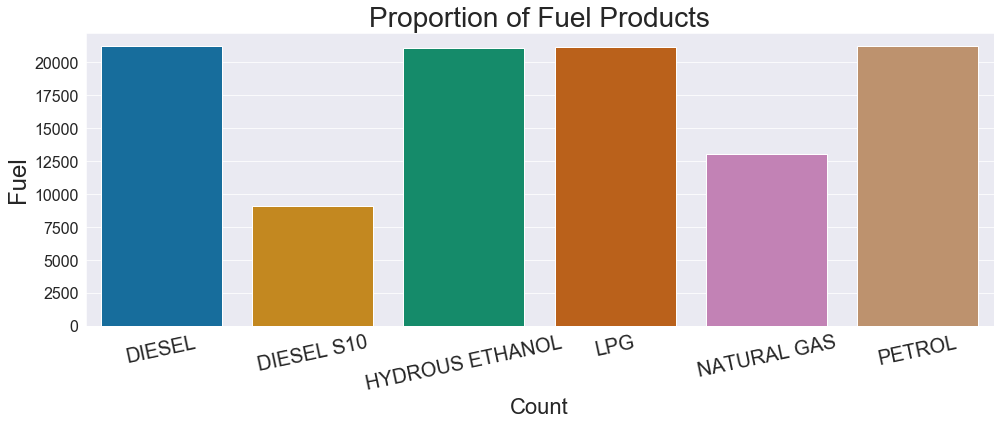

In [21]:
# Countplot of observations per Macroregion
count_plot('Product', df, title="Proportion of Fuel Products", xlabel='Fuel', ylabel='Count', rot=12)

For which years do observations exist for each fuel type?

In [22]:
## Capture list of products
products = df.Product.unique().tolist()

fuel_years = pd.DataFrame()

product_group = df.groupby("Product")

## Extract first and last years of observation for each fuel product
for i, product in enumerate(products):
    
    df_temp = pd.DataFrame({"Product":product, "First_Year":product_group.get_group(product)["Year"].min(), 
                            "Last_Year":product_group.get_group(product)["Year"].max()}, index=[i])
    
    fuel_years = fuel_years.append(df_temp)
    
fuel_years.set_index("Product", inplace=True)

fuel_years

,First_Year,Last_Year
Product,,
HYDROUS ETHANOL,2004,2019
PETROL,2004,2019
LPG,2004,2019
NATURAL GAS,2004,2019
DIESEL,2004,2019
DIESEL S10,2012,2019


Notice that S10 DIESEL observations begin in 2012 while the others begin in 2004. 

What is the proportion of fuel products observed in the dataset in each region?

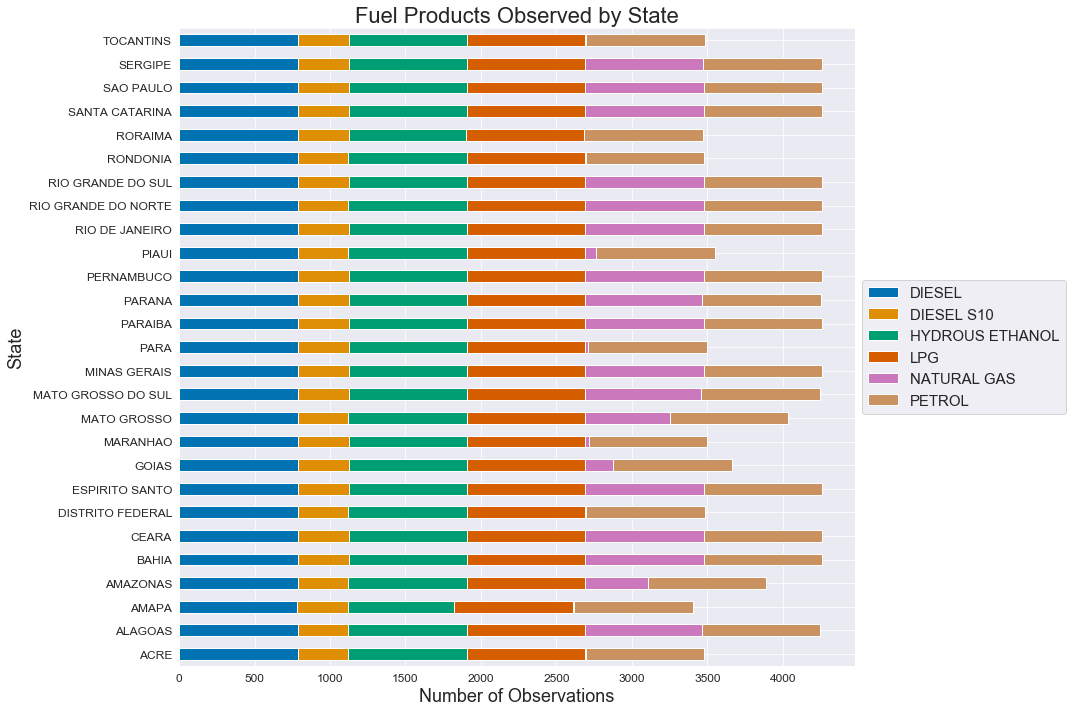

In [23]:
# Group by state
fuels_by_state = df.groupby("State")["Product"].value_counts().to_frame("Count").reset_index()
fuels_by_state = fuels_by_state.pivot("State", "Product")

fig, ax = plt.subplots(figsize=(15,10))

# Horizontal stacked bar chart
fuels_by_state.plot(kind="barh", stacked=True, ax=ax)

plt.title("Fuel Products Observed by State", fontsize=22)
plt.xlabel("Number of Observations", fontsize=18)
plt.ylabel("State", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Sort order was confirmed before customizing legend
ax.legend(sorted(df.Product.unique().tolist()), loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 15})

plt.tight_layout()

plt.show()

#### *Measurement_unit*

Liquid fuels are measured in liters, LPG by 13kg cylinder, and Natural Gas by cubic meter.

In [24]:
df.Measurement_unit.value_counts(normalize=True)

liter    0.679657
13kg     0.198328
m3       0.122015
Name: Measurement_unit, dtype: float64

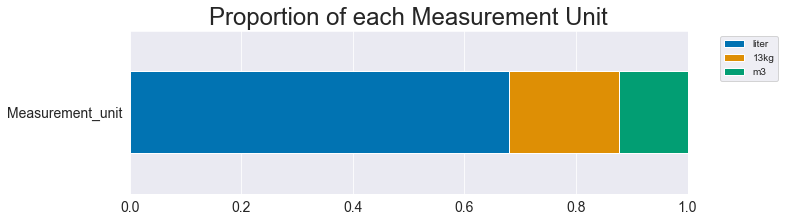

In [25]:
# Graph value counts

fig, ax = plt.subplots(1, 1, figsize=(10,3))

df.Measurement_unit.value_counts(normalize=True).to_frame("Measurement_unit").T.plot(kind="barh", stacked=True, ax=ax,
                                                    fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlim(0, 1)
plt.title("Proportion of each Measurement Unit", fontsize=24)
plt.show()

#### *Price_Group*

Price Group 1 contains ethanol, petrol, diesel and gas, while Price Group 2 contains only LPG

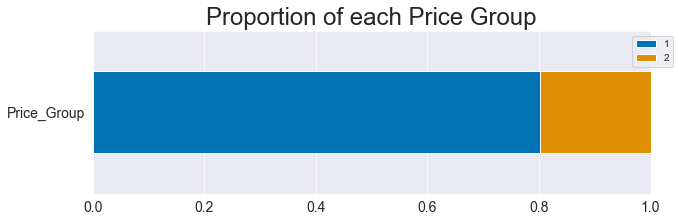

In [26]:
# Graph value counts

fig, ax = plt.subplots(1, 1, figsize=(10,3))

df.Price_Group.value_counts(normalize=True).to_frame("Price_Group").T.plot(kind="barh", stacked=True, ax=ax,
                                                    fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlim(0, 1)
plt.title("Proportion of each Price Group", fontsize=24)
plt.show()

### Numeric Variables

The numeric variables are:
* Analysis_Date
* No_of_Gas_Stations_Analyzed
* Mean_Price
* Mean_Dist_Price
* Month
* Year

#### *Analysis_Date*

This columns is a time unit going by week.

In [27]:
# Display count, start and end dates
count = len(df.Analysis_Date)
start = df.Analysis_Date.min().strftime('%Y-%m-%d')
end = df.Analysis_Date.max().strftime('%Y-%m-%d')

print("The are {} observations beginning on {} and ending {}".format(count, start, end))

The are 106823 observations beginning on 2004-05-09 and ending 2019-06-23


#### *No_of_Gas_Stations_Analyzed*

In [28]:
# Value counts by percentage
df.No_of_Gas_Stations_Analyzed.describe()

count    106823.000000
mean        233.770976
std         403.282519
min           1.000000
25%          42.000000
50%         104.000000
75%         243.000000
max        4167.000000
Name: No_of_Gas_Stations_Analyzed, dtype: float64

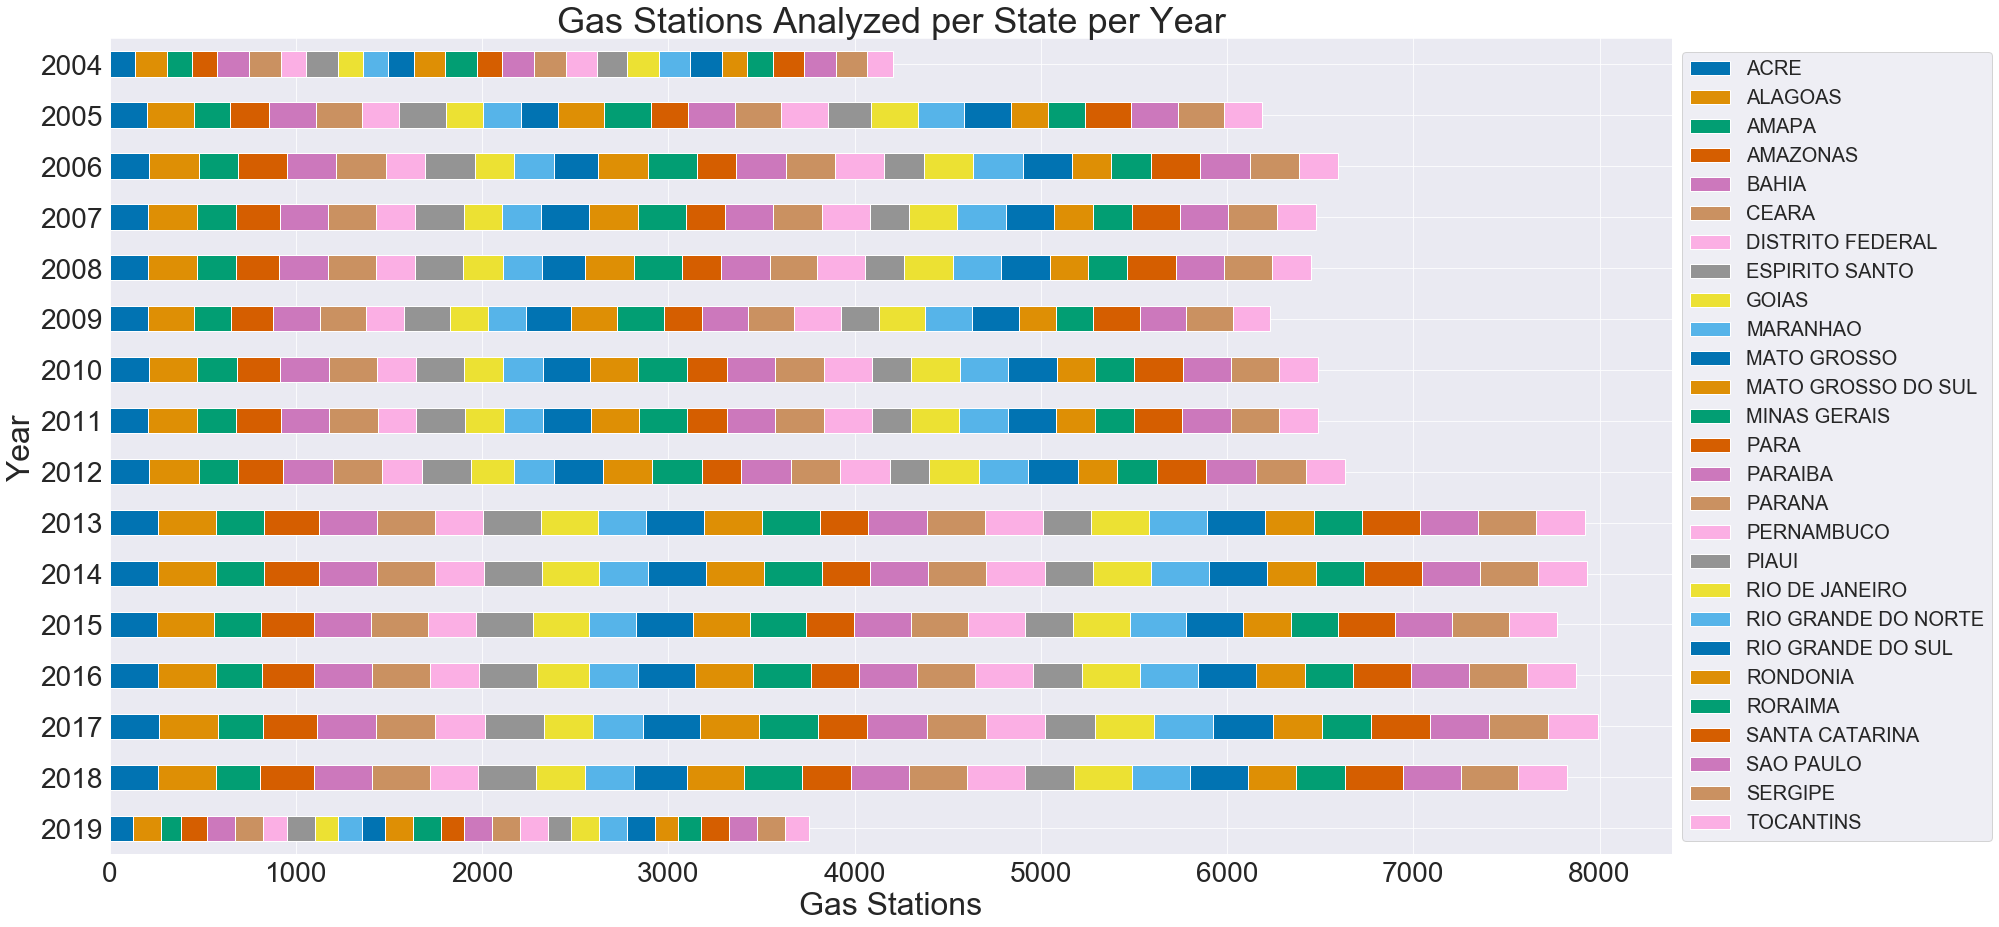

In [29]:
# Create graph of Gas Stations Analyzed per Year
gas_stations_by_year = df.groupby(["Year", "State"])[["No_of_Gas_Stations_Analyzed"]].count().reset_index()

fig, ax = plt.subplots(figsize=(28,15))

gas_stations_by_year.pivot("Year", "State").sort_values(by="Year", ascending=False).plot(kind="barh", stacked=True, ax=ax)

plt.title("Gas Stations Analyzed per State per Year", fontsize=36)
plt.xlabel("Gas Stations", fontsize=32)
plt.ylabel("Year", fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

# Sort order was confirmed before customizing legend
ax.legend(sorted(gas_stations_by_year.State.unique().tolist()), loc='center left', 
          bbox_to_anchor=(1, 0.5), prop={'size': 20})


plt.show()

#### *Mean_Price*

The average price paid by the customer at the pump. This is the main metric we are looking at in the analysis.

In [30]:
df.Mean_Price.describe()

count    106823.000000
mean         10.870780
std          17.752533
min           0.766000
25%           2.072000
50%           2.718000
75%           3.752000
max          99.357000
Name: Mean_Price, dtype: float64

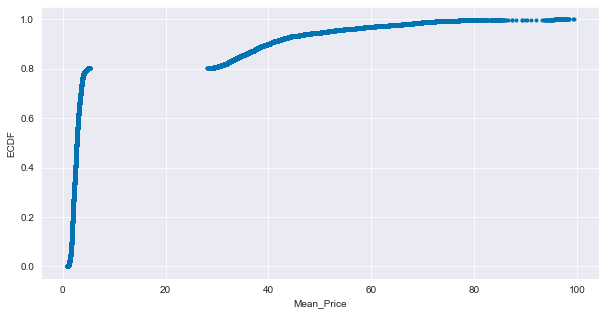

In [31]:
ecdf(df, 'Mean_Price')

The above ECDF plot tells us that the *Mean_Price* variable contains more than one distribution. The question is, what accounts for this? The answer is that each *Product* category has its own distribution, although several of them are in a similar price range.

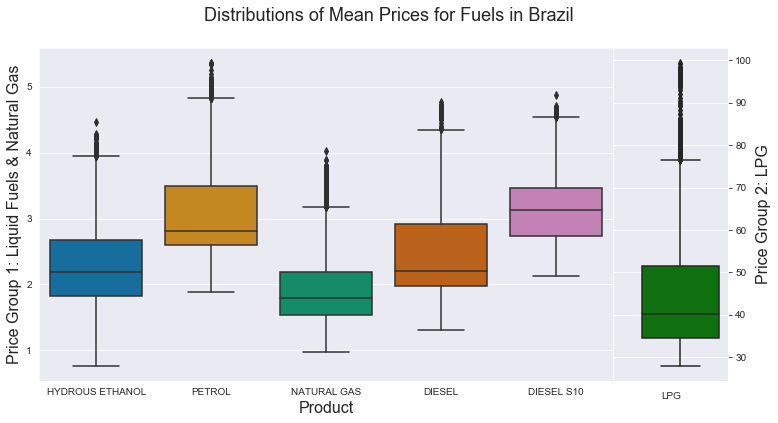

In [32]:
# Create a boxplot out of two separate axes with different scales
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6.5), gridspec_kw={"width_ratios":[5,1], "wspace":0})

# Axis for Products with similar means
sns.boxplot(x="Product", y="Mean_Price", data=df[df.Product!="LPG"], order=["HYDROUS ETHANOL", "PETROL", 
                                                              "NATURAL GAS", "DIESEL", "DIESEL S10"], 
            ax=ax[0])

# Axis for LPG
sns.boxplot(x="Product", y="Mean_Price", data=df[df.Product=="LPG"], ax=ax[1], color='g', width=4)

plt.suptitle("Distributions of Mean Prices for Fuels in Brazil", fontsize=18)

# Format LPG plot
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[0].set_xlabel('Product', fontsize=16)
ax[1].set_xlabel('LPG')
ax[0].set_ylabel('Price Group 1: Liquid Fuels & Natural Gas', fontsize=16)
ax[1].set_ylabel('Price Group 2: LPG', fontsize=16)
ax[1].set(xticklabels=[])


# Add subplot for LPG
plt.tight_layout(pad=5)

Create separate *Mean_Price* ECDF plots for each fuel product:

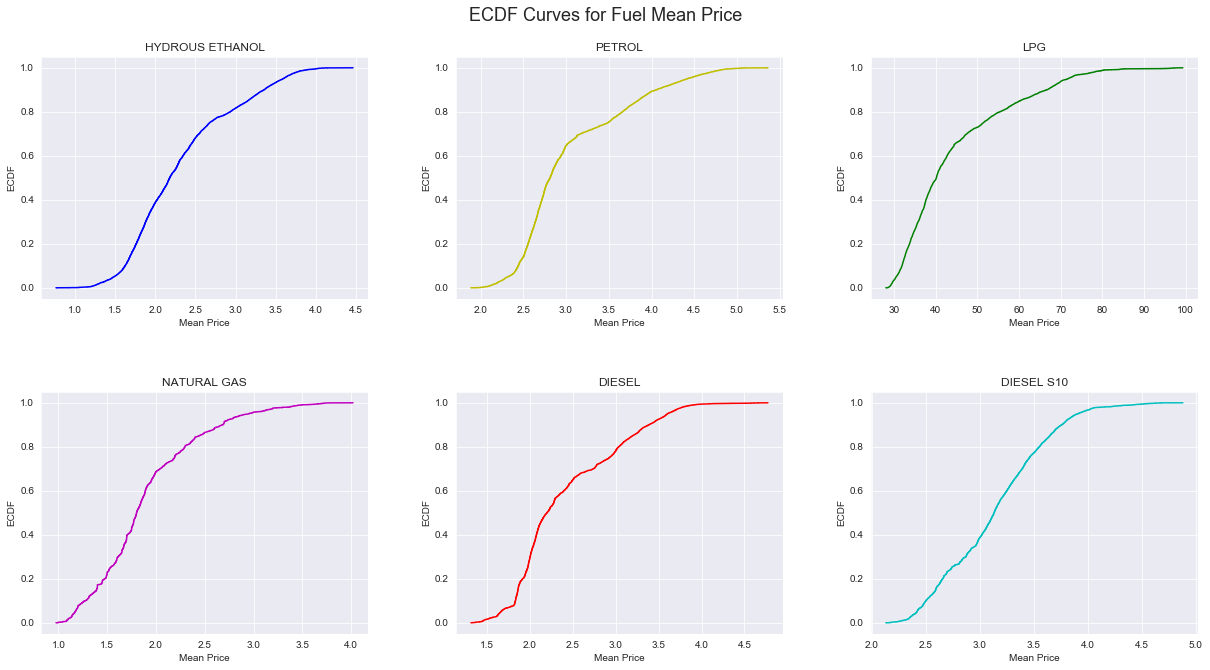

In [33]:
ecdf_category("Mean_Price", "Product", title="ECDF Curves for Fuel Mean Price", xlabel="Mean Price")

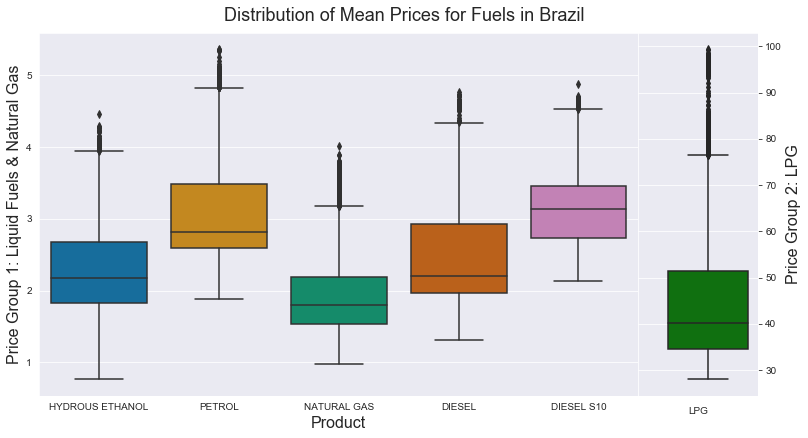

In [34]:
# Create a boxplot out of two separate axes with different scales
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6.5), gridspec_kw={"width_ratios":[5,1], "wspace":0})

# Axis for Products with similar means
sns.boxplot(x="Product", y="Mean_Price", data=df[df.Product!="LPG"], order=["HYDROUS ETHANOL", "PETROL", 
                                                              "NATURAL GAS", "DIESEL", "DIESEL S10"], 
            ax=ax[0])

# Axis for LPG
sns.boxplot(x="Product", y="Mean_Price", data=df[df.Product=="LPG"], ax=ax[1], color='g', width=4)

plt.suptitle("Distribution of Mean Prices for Fuels in Brazil", fontsize=18)

# Format LPG plot
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[0].set_xlabel('Product', fontsize=16)
ax[1].set_xlabel('LPG')
ax[0].set_ylabel('Price Group 1: Liquid Fuels & Natural Gas', fontsize=16)
ax[1].set_ylabel('Price Group 2: LPG', fontsize=16)
ax[1].set(xticklabels=[])


# Add subplot for LPG
plt.tight_layout(pad=3.5)

*Mean_Price* Time Series plots:

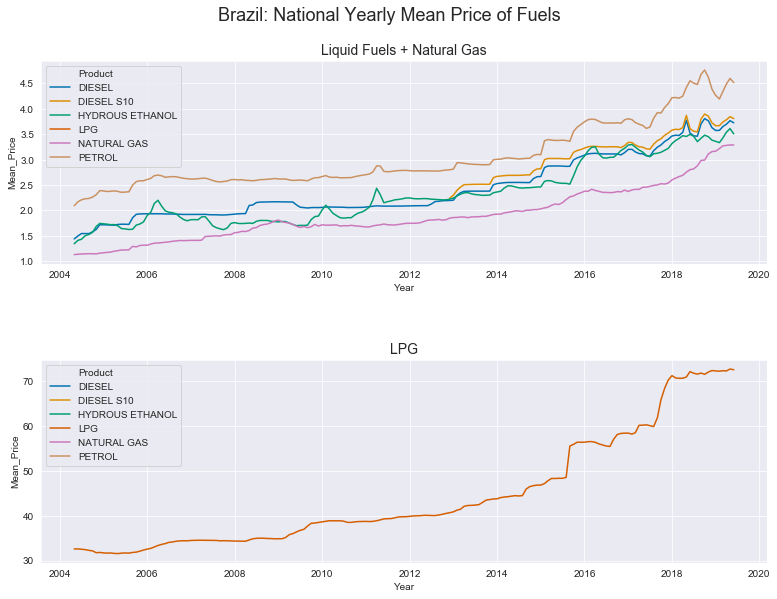

In [35]:
# Plot yearly Mean_Price
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,9))

# Plot of fuels not including LPG
sns.lineplot(x="Year_Month", y="Mean_Price", data=df[df.Product!="LPG"], hue="Product", ax=ax[0], err_style=None)
ax[0].set_xlabel("Year")
ax[0].set_title("Liquid Fuels + Natural Gas", fontsize=14)

# Plot of LPG
sns.lineplot(x="Year_Month", y="Mean_Price", data=df[df.Product == "LPG"], hue="Product", ax=ax[1], err_style=None)
ax[1].set_xlabel("Year")
ax[1].set_title("LPG", fontsize=14)

plt.suptitle("Brazil: National Yearly Mean Price of Fuels", fontsize=18)
plt.tight_layout(pad=5)
plt.show()

#### *Mean_Dist_Price*

The average wholesale price paid by supplier. While not being used in the analysis, it's included because of some interesting behavior it has:

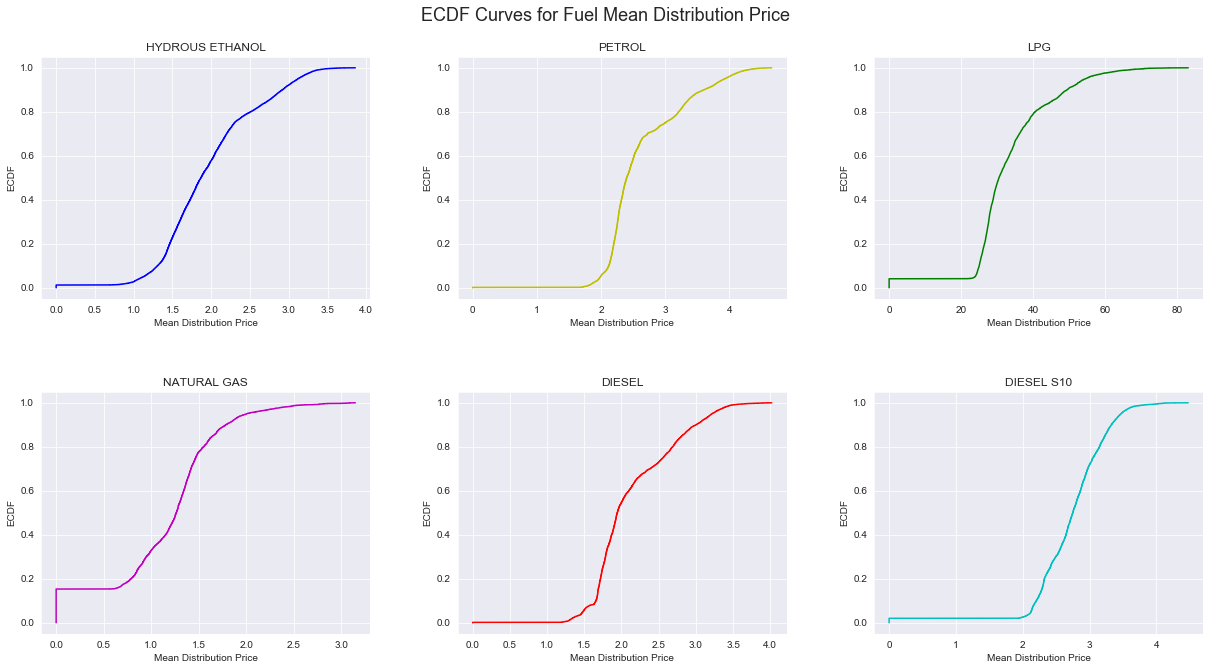

In [36]:
ecdf_category("Mean_Dist_Price", "Product", title="ECDF Curves for Fuel Mean Distribution Price", 
             xlabel="Mean Distribution Price")

Note the horizontal and vertical lines, what do these mean? It is possible there were price controls in effect for some fuels.

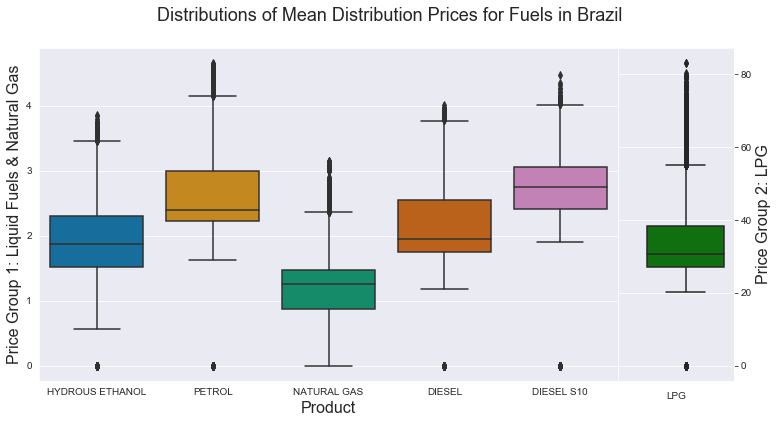

In [37]:
# Create a boxplot out of two separate axes with different scales
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6.5), gridspec_kw={"width_ratios":[5,1], "wspace":0})

# Axis for Products with similar means
sns.boxplot(x="Product", y="Mean_Dist_Price", data=df[df.Product!="LPG"], order=["HYDROUS ETHANOL", "PETROL", 
                                                              "NATURAL GAS", "DIESEL", "DIESEL S10"], 
            ax=ax[0])

# Axis for LPG
sns.boxplot(x="Product", y="Mean_Dist_Price", data=df[df.Product=="LPG"], ax=ax[1], color='g', width=4)

plt.suptitle("Distributions of Mean Distribution Prices for Fuels in Brazil", fontsize=18)

# Format LPG plot
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[0].set_xlabel('Product', fontsize=16)
ax[1].set_xlabel('LPG')
ax[0].set_ylabel('Price Group 1: Liquid Fuels & Natural Gas', fontsize=16)
ax[1].set_ylabel('Price Group 2: LPG', fontsize=16)
ax[1].set(xticklabels=[])


# Add subplot for LPG
plt.tight_layout(pad=5)

*Mean_Dist_Price* Time Series plots:

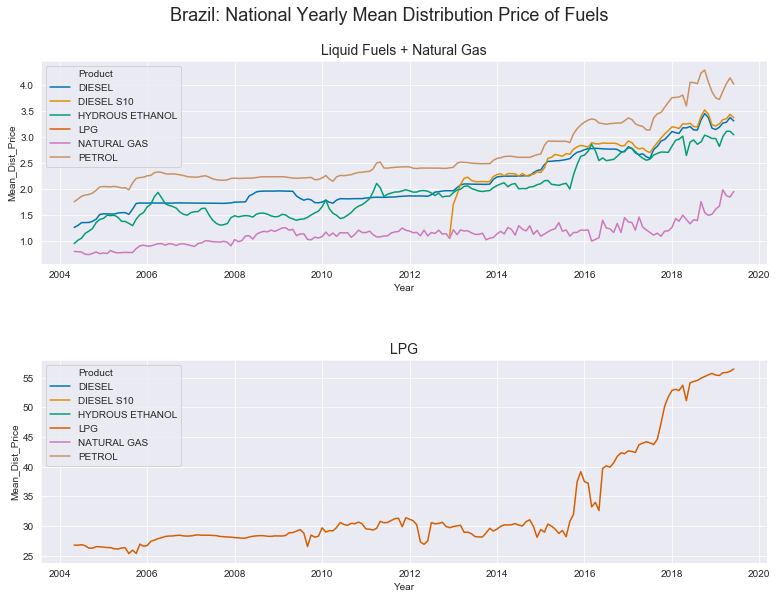

In [38]:
# Plot yearly Mean_Price
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,9))

# Plot of fuels not including LPG
sns.lineplot(x="Year_Month", y="Mean_Dist_Price", data=df[df.Product!="LPG"], hue="Product", ax=ax[0], err_style=None)
ax[0].set_xlabel("Year")
ax[0].set_title("Liquid Fuels + Natural Gas", fontsize=14)

# Plot of LPG
sns.lineplot(x="Year_Month", y="Mean_Dist_Price", data=df[df.Product == "LPG"], hue="Product", ax=ax[1], err_style=None)
ax[1].set_xlabel("Year")
ax[1].set_title("LPG", fontsize=14)

plt.suptitle("Brazil: National Yearly Mean Distribution Price of Fuels", fontsize=18)
plt.tight_layout(pad=5)
plt.show()

# Questions

* How did the price change for the different regions of Brazil?
* Within a region, which states increased their prices the most?
* Which states are the cheapest (or most expensive) for different types of fuels?

To answer these questions we will 1) include geographical shape files of Brazil's states and 2) create a new dataframe containing the percent change in prices.

## Geographic Data

In [39]:
# URL to shape files of Brazil's states, made public courtesy of the Brazilian government
#url = "ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2016/Brasil/BR/br_unidades_da_federacao.zip"

url= '../data/external/br_unidades_da_federacao/'

brazil_geo = gpd.read_file(url)

# Correct state names to match current dataset
state_dict = {"RONDÔNIA":"RONDONIA", "PARÁ":"PARA", "AMAPÁ":"AMAPA", "MARANHÃO":"MARANHAO",
             "PIAUÍ":"PIAUI", "CEARÁ":"CEARA", "PARAÍBA":"PARAIBA", "ESPÍRITO SANTO":"ESPIRITO SANTO",
             "SÃO PAULO":"SAO PAULO", "PARANÁ":"PARANA", "GOIÁS":"GOIAS", "ACRE":"ACRE",
             "AMAZONAS":"AMAZONAS", "RORAIMA":"RORAIMA", "TOCANTINS":"TOCANTINS", 
             "RIO GRANDE DO NORTE":"RIO GRANDE DO NORTE", "PERNAMBUCO":"PERNAMBUCO", 
             "ALAGOAS":"ALAGOAS", "SERGIPE":"SERGIPE", "BAHIA":"BAHIA", "MINAS GERAIS":"MINAS GERAIS",
             "RIO DE JANEIRO":"RIO DE JANEIRO", "SANTA CATARINA":"SANTA CATARINA", "MATO GROSSO DO SUL":"MATO GROSSO DO SUL", 
             "MATO GROSSO":"MATO GROSSO", "DISTRITO FEDERAL":"DISTRITO FEDERAL", "RIO GRANDE DO SUL":"RIO GRANDE DO SUL"}

brazil_geo["NM_ESTADO"] = brazil_geo.NM_ESTADO.map(state_dict)

brazil_geo.crs = {"init": "epsg:4326"}

brazil_geo.columns = ['State', 'Macroregion', 'CD_GEOCUF', 'geometry']

brazil_geo["Macroregion"] = brazil_geo.Macroregion.str.replace("-", " ")

# Extract regions geography
brazil_geo_region = brazil_geo.dissolve(by='Macroregion').reset_index()
brazil_geo_region = brazil_geo_region[['Macroregion', 'geometry']]

## Percent Change in Price Data

In [40]:
# Create dataframe df_pct_change with percent change of prices

macroregions = df.Macroregion.unique().tolist()

df_pct_change = pd.DataFrame()

count = 0

for i in range(len(macroregions)):
    region = macroregions[i]
    states = df[df.Macroregion==region]["State"].unique()
    
    for i in range(len(states)):
        state = states[i]
        products = df[(df.Macroregion==region) & (df.State==state)]["Product"].unique()
       
        for i in range(len(products)):
            product = products[i]
            years = df[(df.Macroregion==region) & (df.State==state) & (df.Product==product)]["Year"].unique()
            
            mean_price = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product)]["Mean_Price"].mean()
            
            # Percent change for raw data
            first_price = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[0])]["Mean_Price"].iloc[0]
            last_price = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[-1])]["Mean_Price"].iloc[-1]
            price_pct_change = (last_price - first_price) / np.abs(first_price)
        
        
            # Percent change for Normalized data
            first_price_norm = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[0])]["Mean_Price_Norm"].iloc[0]
            last_price_norm = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[-1])]["Mean_Price_Norm"].iloc[-1]
            price_pct_change_norm = (last_price_norm - first_price_norm) / np.abs(first_price_norm)            
            
            # Add to dataframe
            df_temp = pd.DataFrame({"Macroregion":region, "State":state, 
                                    "Product":product, 
                                    "First_Year":years[0], "Last_Year":years[-1], "Fuel_Mean_Price":mean_price,
                                    "First_Price":first_price, "Last_Price":last_price, "Price_Pct_Change":price_pct_change, 
                                    "First_Price_Norm":first_price_norm, "Last_Price_Norm":last_price_norm, 
                                    "Price_Pct_Change_Norm":price_pct_change_norm
                                   }, 
                                   index=[count])
            
            df_pct_change = df_pct_change.append(df_temp)
            
            count += 1

/Users/gregory/anaconda3/envs/brazil_fuel_price_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


## Merging Percentage Change Price with Geographic Data

In [41]:
# Group by percentage change by macroregion
df_pct_change_region = df_pct_change.groupby(['Macroregion', 'Product']).mean().reset_index()

# Merge new datasets with spatial data
brazil_geo = brazil_geo.drop('Macroregion', axis=1).merge(df_pct_change, on='State')
brazil_geo_region = brazil_geo_region.merge(df_pct_change_region, on='Macroregion')

# Correct datatypes
for col in ['First_Year', 'Last_Year']:
    brazil_geo_region[col] = brazil_geo_region[col].astype(int)

# Save geographical data to disk
brazil_geo.to_csv('../data/interim/brazil_geo.csv')
brazil_geo_region.to_csv('../data/interim/brazil_geo_region.csv')

## *1. How did the price change for the different regions of Brazil?*

To investigate the question of how price changed by region we will create a choropleth map varying by the percentage change in price for each fuel for the entire time data is available.

#### Choropleth: Mean Price Percentage Change by Region

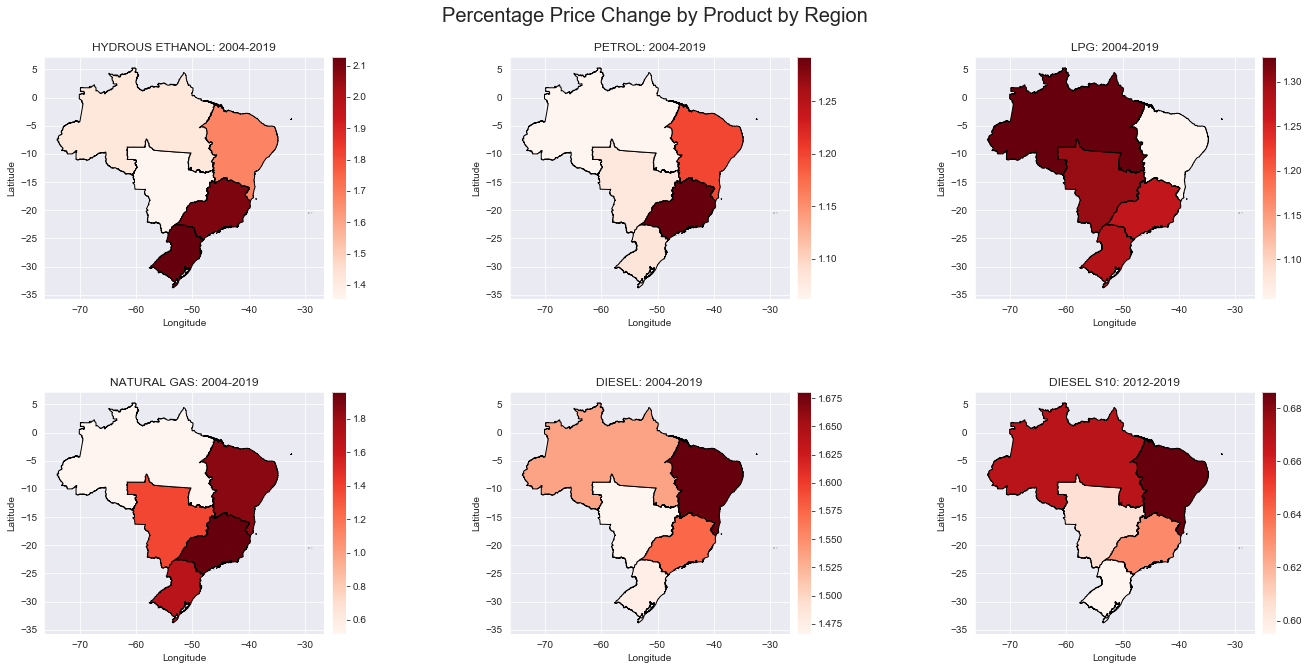

In [42]:
# Create plot with raw price data: choropleth_product(data, column, title, cmap)
nrows = 2
ncols = 3
products = df.Product.unique().tolist()

fig_raw, ax_raw = plt.subplots(figsize=(20,10), nrows=nrows, ncols=ncols)

n = 0

for row in range(nrows):
   
    for col in range(ncols):
        
        divider = make_axes_locatable(ax_raw[row,col])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        brazil_geo_region[brazil_geo_region.Product==products[n]].plot(column="Price_Pct_Change", 
                                                                       legend=True, ax=ax_raw[row,col], cmap="Reds", 
                                                                       cax=cax, edgecolor='black')
        
        # Plot titles
        year_range = brazil_geo_region[brazil_geo_region.Product==products[n]][["First_Year", "Last_Year"]]
        year_range = [year_range["First_Year"].min(), year_range["Last_Year"].max()]
        year_range = str(year_range[0]) + "-" + str(year_range[1])
        
        ax_raw[row,col].set_title(products[n] + ": " + year_range, fontsize=20)
        ax_raw[row,col].set_xlabel("Longitude", fontsize=18)
        ax_raw[row,col].set_ylabel("Latitude", fontsize=18)
        n += 1

fig_raw.suptitle("Brazil: Mean Price Percentage Change by Product by Region", fontsize=28)
plt.tight_layout(pad=5)
plt.show()

#### Discussion

The choropleth provides an easy idea to how prices have changed for different fuel products in Brazil. It is important to keep in mind however that the colors of one map should not be compared with those of another map because of the difference in scale: each specific color on a map represents a value unique to that map.

Note: The plotting functions will be converted to a function but for now code is copied & pasted.

## *2. Within a region, which states increased their prices the most?*

Create a new dataframe to show percent change during the period data was collected:

#### Choropleth: Mean Price Percentage Change by Product by State

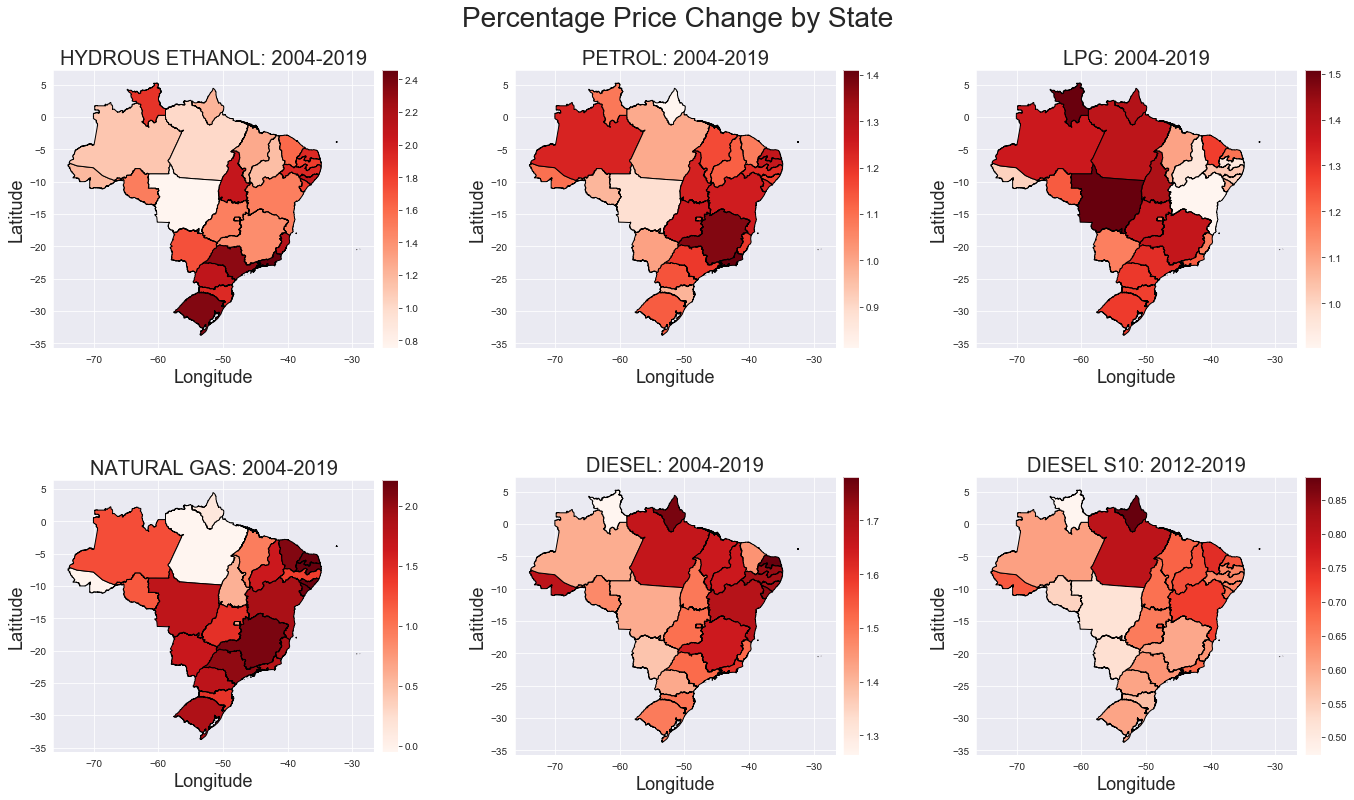

In [43]:
# Create plot function with raw price data: choropleth_product(data, column, title, cmap)
nrows = 2
ncols = 3
products = df.Product.unique().tolist()

fig_raw, ax_raw = plt.subplots(figsize=(20,12), nrows=nrows, ncols=ncols)

n = 0

for row in range(nrows):
   
    for col in range(ncols):
        
        divider = make_axes_locatable(ax_raw[row,col])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        brazil_geo[brazil_geo.Product==products[n]].plot(column="Price_Pct_Change", 
                                                                       legend=True, ax=ax_raw[row,col], cmap="Reds", 
                                                                       cax=cax, edgecolor='black')
        
        # Plot titles
        year_range = brazil_geo[brazil_geo.Product==products[n]][["First_Year", "Last_Year"]]
        year_range = [year_range["First_Year"].min(), year_range["Last_Year"].max()]
        year_range = str(year_range[0]) + "-" + str(year_range[1])
        
        ax_raw[row,col].set_title(products[n] + ": " + year_range, fontsize=20)
        ax_raw[row,col].set_xlabel("Longitude", fontsize=18)
        ax_raw[row,col].set_ylabel("Latitude", fontsize=18)
        n += 1

fig_raw.suptitle("Brazil: Mean Price Percentage Change by Product by State", fontsize=28)
plt.tight_layout(pad=5)
plt.show()

#### Discussion

It is interesting to see how prices have changed in each state for the years indicated in the data. Making any concrete comparisons should rely on a quantitative analysis of price differences, but for the purpose of exploring the data the choropleths give a quick idea as to the price behavior.

## *3. Which states are the cheapest (or most expensive) for different types of fuels?*

#### Choropleth: Mean Price of Fuels by State

In [45]:
# Group by State and Product
brazil_fuel_state = brazil_geo.groupby(["State", "Product"])["Fuel_Mean_Price"].mean().reset_index()

# Rejoin with spatial data
brazil_fuel_state_geo = brazil_geo.merge(brazil_fuel_state.drop(['Product','Fuel_Mean_Price'], axis=1) , on="State")

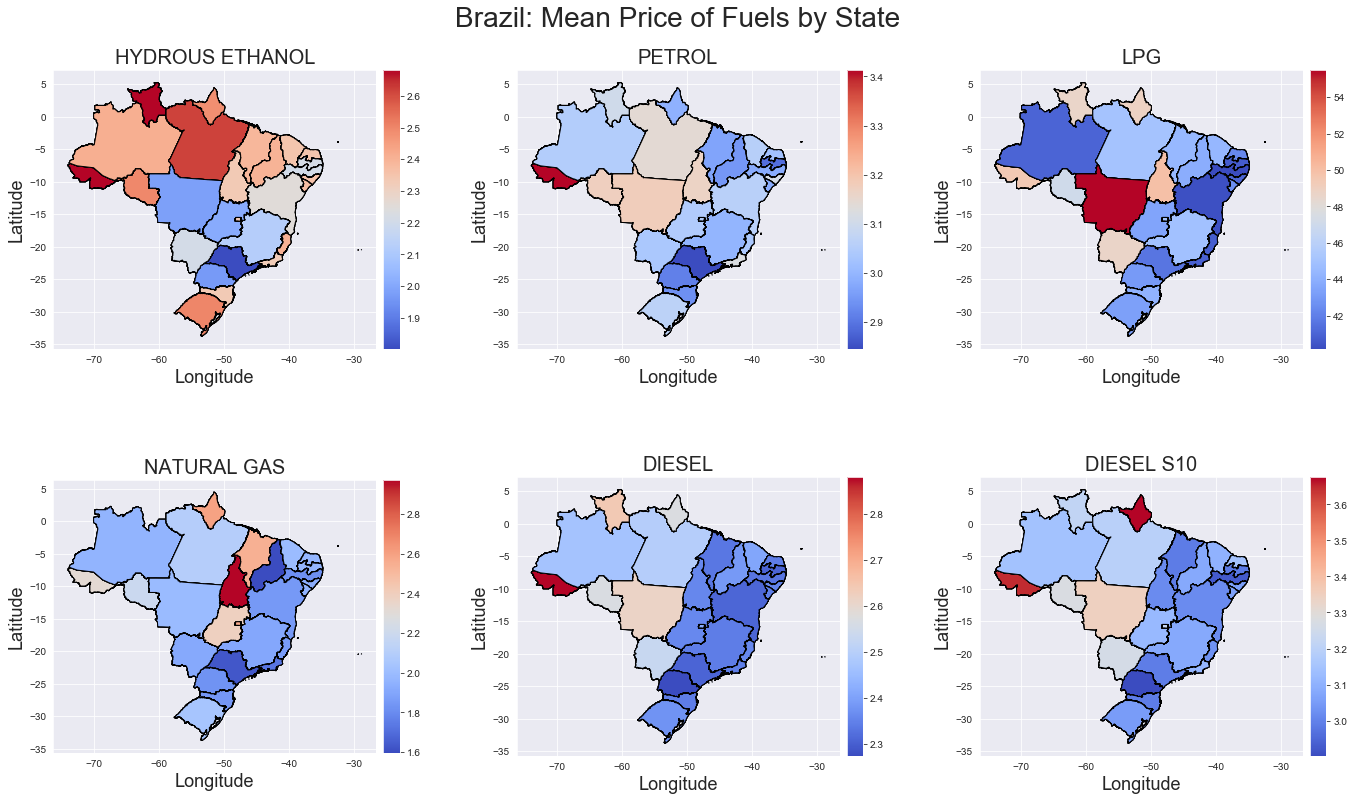

In [46]:
# Create plot function with raw price data: choropleth_product(data, column, title, cmap)
nrows = 2
ncols = 3
products = df.Product.unique()

fig, ax = plt.subplots(figsize=(20,12), nrows=nrows, ncols=ncols)

# set counter
n = 0

# Iterate through figure axes
for row in range(nrows): # iterate through rows
   
    for col in range(ncols): # iterate through each column while on one row
        
        # Adjust location and size of legend
        divider = make_axes_locatable(ax[row,col]) 
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        # Plot choropleth
        brazil_fuel_state_geo[brazil_fuel_state_geo.Product==products[n]].plot(column="Fuel_Mean_Price", 
                                                                       cmap="coolwarm", 
                                                                       legend=True, ax=ax[row,col], 
                                                                       cax=cax, edgecolor='black')
        
        # Set title and labels
        ax[row,col].set_title(products[n], fontsize=20)
        ax[row,col].set_xlabel("Longitude", fontsize=18)
        ax[row,col].set_ylabel("Latitude", fontsize=18)
        
        n += 1

fig.suptitle("Brazil: Mean Price of Fuels by State", fontsize=28)
plt.tight_layout(pad=5)
plt.show()

#### Choropleth: Most and Least Expensive Fuels by State

In [47]:
states = brazil_fuel_state.State.unique().tolist()

# Create dataframe of cheapest fuels by state
cheapest_fuels = pd.DataFrame()

# Iterate through group-by objects and extract minimum: extreme_of_group(data, column, extreme)
for i in range(len(states)):

    state_group = brazil_fuel_state_geo.groupby("State").get_group(states[i])
    state_group = state_group[state_group.Fuel_Mean_Price == state_group.Fuel_Mean_Price.min()]
    cheapest_fuels = cheapest_fuels.append(state_group)
    cheapest_fuels.rename({"Fuel_Mean_Price":"Fuel_Min_Price"}, inplace=True)
    
# Create dataframe of cheapest fuels by state
expensive_fuels = pd.DataFrame()

# Remove LPG from list of products
brazil_fuel_state_geo_noLPG = brazil_fuel_state_geo[brazil_fuel_state_geo.Product!="LPG"]

# Iterate through group-by objects and extract minimum: extreme_of_group(data, column, extreme)
for i in range(len(states)):

    state_group = brazil_fuel_state_geo_noLPG.groupby("State").get_group(states[i])
    state_group = state_group[state_group.Fuel_Mean_Price == state_group.Fuel_Mean_Price.max()]
    expensive_fuels = expensive_fuels.append(state_group)
    expensive_fuels.rename({"Fuel_Mean_Price":"Fuel_Max_Price"}, inplace=True)

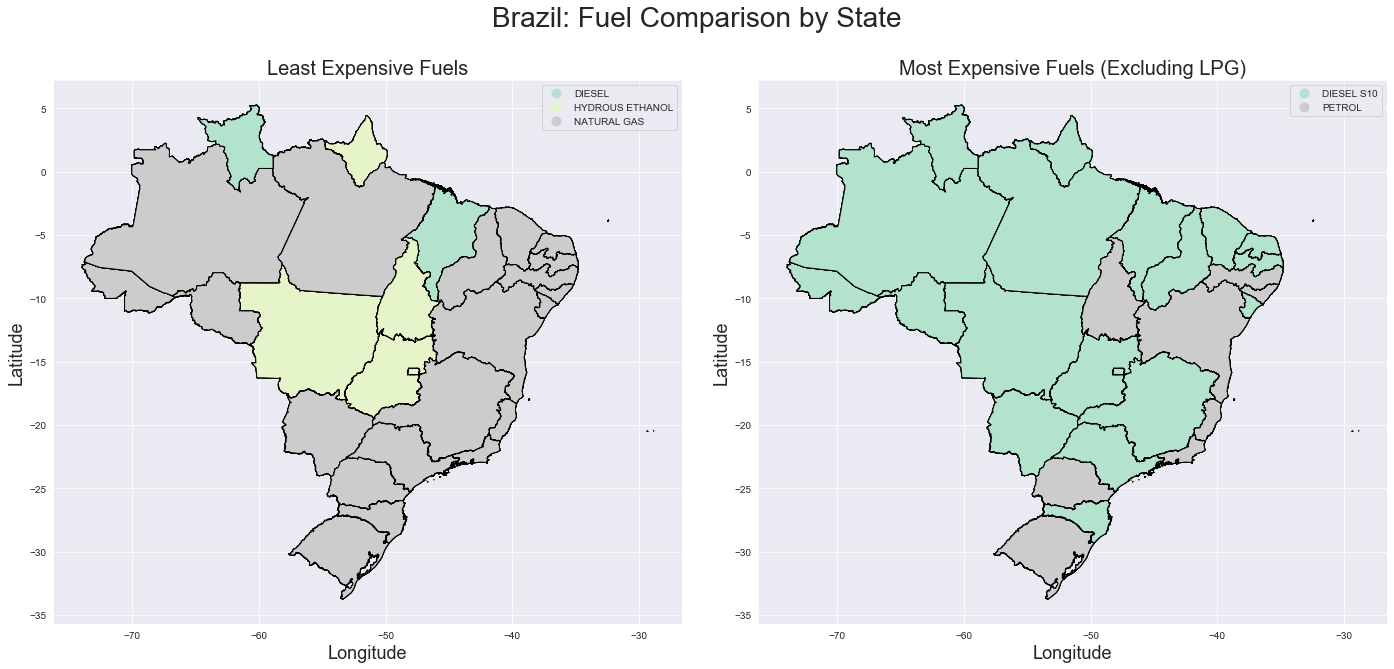

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Choropleths of cheapest and most expensive fuels
expensive_fuels.plot(column="Product", cmap="Pastel2", legend=True, ax=ax[1], edgecolor='black')
cheapest_fuels.plot(column="Product", cmap="Pastel2", legend=True, ax=ax[0], edgecolor='black')

# Format figure and axes
ax[0].set_title("Least Expensive Fuels", fontsize=20)
ax[1].set_title("Most Expensive Fuels (Excluding LPG)", fontsize=20)
ax[0].set_ylabel("Latitude", fontsize=18)
ax[0].set_xlabel("Longitude", fontsize=18)
ax[1].set_ylabel("Latitude", fontsize=18)
ax[1].set_xlabel("Longitude", fontsize=18)

plt.suptitle("Brazil: Fuel Comparison by State", fontsize=28)
plt.tight_layout(pad=3)
plt.show()

# Conclusion

This concludes the geospatial analysis. A thorough report on the topic would also include more quantitative analysis in addition to the graphs but for this an initial exploration the visualizations give a good idea as to patterns and behavior of the data.